In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import ast

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import (
    train_test_split, KFold, RandomizedSearchCV, cross_val_score)
from sklearn.metrics import (r2_score, mean_squared_error, make_scorer)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder
)
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import accuracy_score

import itertools
import random

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
warnings.filterwarnings('ignore')

# Import Dataset Following EDA

In [2]:
df_filtered = pd.read_csv("Worker_EDA_Complete.csv")

In [3]:
df_filtered

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,air_trip_distance_miles,city_from_zip,gender,age,citizen,...,transmission,cylinders,veh_type,departure_datetime,departure_hour,day_of_week,month,season,is_weekend,time_of_day
0,3.0,2.0,Auto Driver,20.0,3.619057,2.740749,Greater Los Angeles Area,1.0,46.0,1.0,...,1.0,4.0,2.0,2012-05-12 08:15:00,8,Saturday,May,Spring,Weekend,Morning
1,5.0,4.0,Auto Driver,20.0,3.587950,2.740749,Greater Los Angeles Area,1.0,46.0,1.0,...,1.0,4.0,2.0,2012-05-12 15:30:00,15,Saturday,May,Spring,Weekend,Afternoon
2,2.0,1.0,Auto Driver,25.0,19.351621,17.693651,Greater Los Angeles Area,1.0,46.0,1.0,...,1.0,4.0,2.0,2012-05-12 16:30:00,16,Saturday,May,Spring,Weekend,Afternoon
3,2.0,1.0,Auto Driver,15.0,6.451126,3.423215,Greater Los Angeles Area,1.0,46.0,1.0,...,1.0,4.0,2.0,2012-05-12 17:40:00,17,Saturday,May,Spring,Weekend,Afternoon
4,2.0,1.0,Auto Driver,20.0,17.657172,15.176484,Greater Los Angeles Area,1.0,46.0,1.0,...,1.0,4.0,2.0,2012-05-12 18:40:00,18,Saturday,May,Spring,Weekend,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94686,1.0,0.0,Auto Driver,4.0,0.181507,0.112927,San Francisco Bay Area,1.0,45.0,1.0,...,0.0,0.0,0.0,2013-01-30 15:58:00,15,Wednesday,January,Winter,Weekday,Afternoon
94687,1.0,0.0,Auto Driver,14.0,2.674467,2.559951,San Francisco Bay Area,1.0,45.0,1.0,...,0.0,0.0,0.0,2013-01-30 16:33:00,16,Wednesday,January,Winter,Weekday,Afternoon
94688,1.0,0.0,Active Transportation,17.0,2.621383,2.391379,San Francisco Bay Area,1.0,45.0,1.0,...,0.0,0.0,0.0,2013-01-30 17:08:00,17,Wednesday,January,Winter,Weekday,Afternoon
94689,1.0,0.0,Active Transportation,94.0,10.356760,8.277860,San Francisco Bay Area,1.0,45.0,1.0,...,0.0,0.0,0.0,2013-01-30 17:43:00,17,Wednesday,January,Winter,Weekday,Afternoon


After importing of a csv, we need to modfiy columns to specific datetypes and remove redundant columns.

In [ ]:
df_filtered['departure_datetime'] = pd.to_datetime(df_filtered['departure_datetime'])
df_filtered.drop(columns=["employment", "student"], inplace=True)

# Create a new date of week column with numerical days of week
df_filtered['day_of_week_num'] = df_filtered['departure_datetime'].dt.dayofweek

# Inital Model Fitting for Identification of All Feature Importances

In [5]:
def selected_feature(data):
    
    feature_selected = df_filtered.select_dtypes(include=['number']).columns.tolist()

    selected_data = data[feature_selected]
    
    return selected_data

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Split the data into train and temp for further split
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['mode_category'], random_state=42)

# Split the temp set into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)
X_train = selected_feature(train_df)
y_train = train_df['mode_category']

# Use SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Driver': 48509, 'Active Transportation': 8419, 'Auto Passenger': 7297, 'Transit': 2058})
Class distribution after SMOTE: Counter({'Auto Driver': 48509, 'Auto Passenger': 48509, 'Transit': 48509, 'Active Transportation': 48509})
Training set size: 194036
Validation set size: 14204
Test set size: 14204


In [7]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)

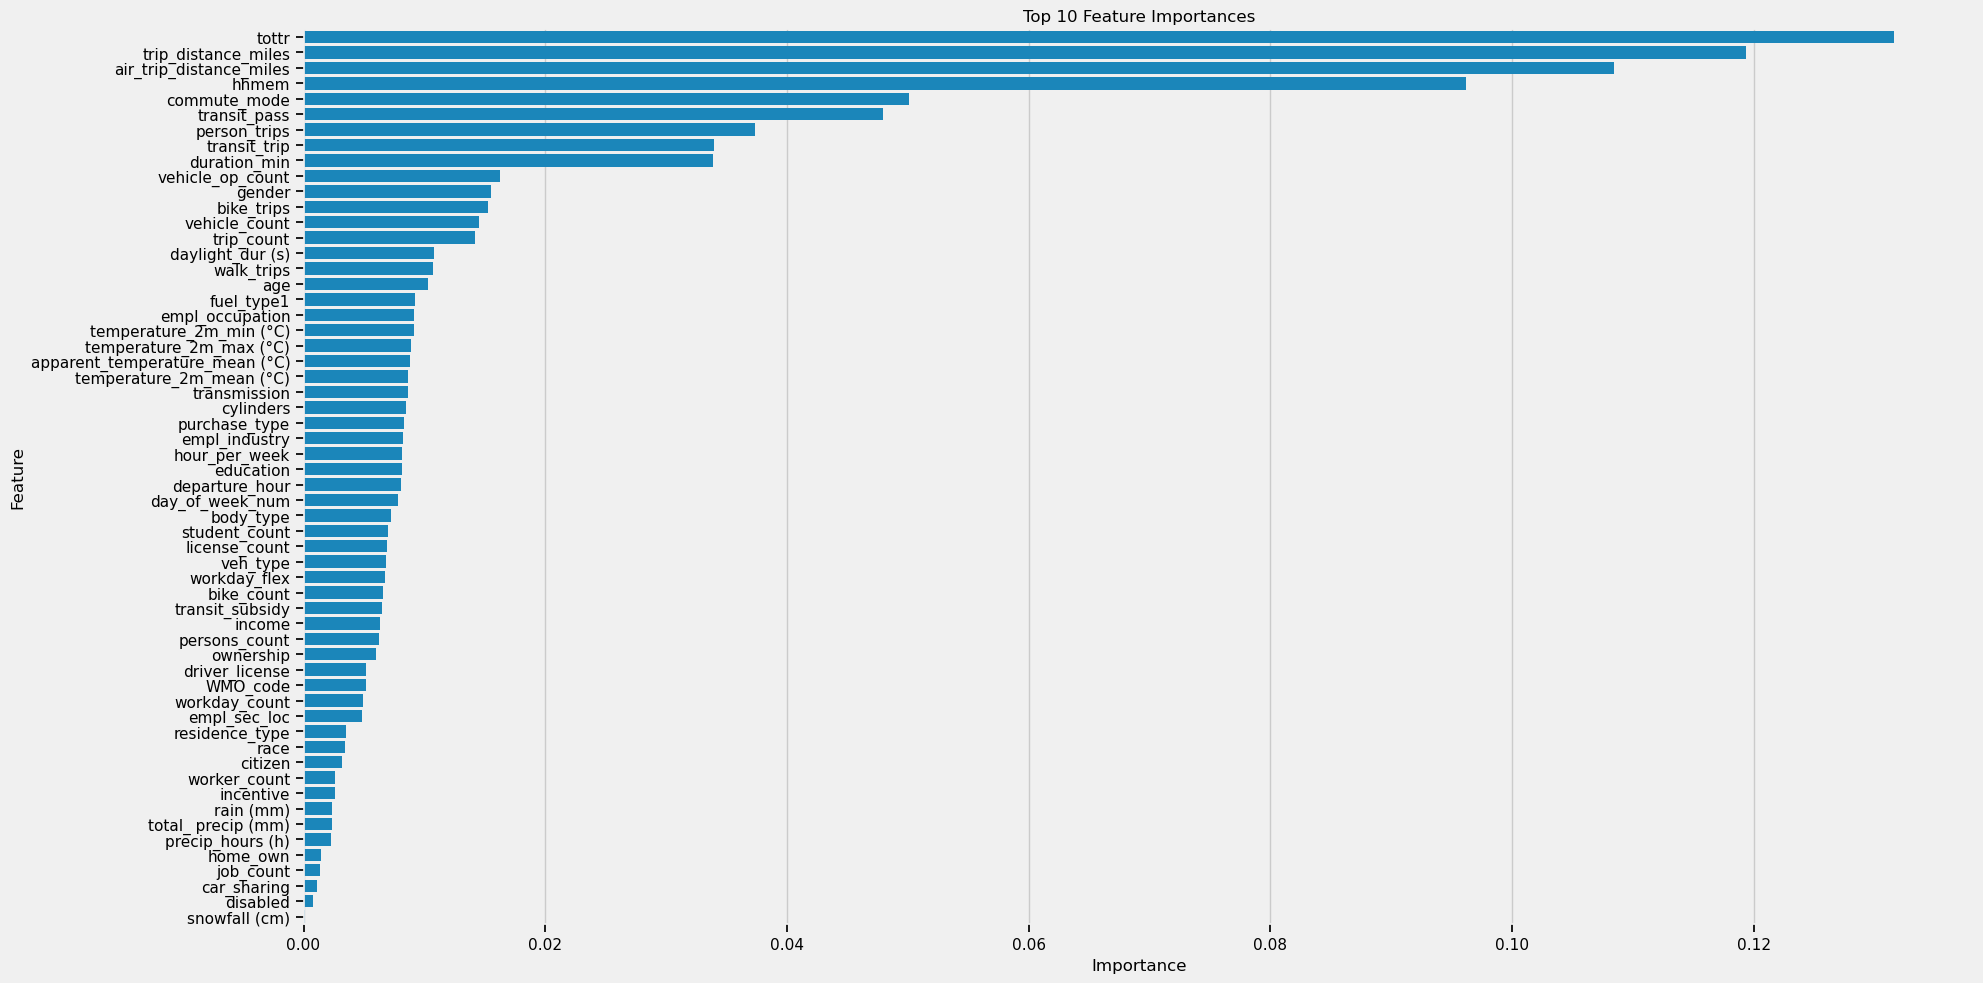

In [8]:
# Feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# Feature Engineering

In [ ]:
# Function to handle 'nan' and numbers in a string list
def convert_list_to_int_or_nan(x):
    if isinstance(x, str):
        # Convert string to list using ast.literal_eval
        x = ast.literal_eval(x)

    # Process the list, convert numeric strings to int and 'nan' to np.nan
    result = []
    for val in x:
        if isinstance(val, str):
            # If it's a string number (e.g., '5.0', '6.0'), convert to float or int
            if val.lower() != 'nan':
                result.append(int(float(val)))  # Convert numeric string to an integer
            else:
                result.append(np.nan)  # Replace 'nan' string with np.nan
        elif isinstance(val, (float, int)):
            result.append(int(val))  # Convert numeric types to integer
        else:
            result.append(np.nan)  # Handle non-numeric values

    return result

The function `check_workday()` compares the day of the week of the travel time to the days the individual travels to determine whether a trip can be assigned as a worktrip or not.

In [10]:
def check_workday(travel_date, workday_range):
    # If the person works Monday to Friday (8)
    if 8 in workday_range:
        if travel_date == 5 or travel_date == 6:  # Saturday (5) or Sunday (6)
            return 2  # Not a workday
        else:
            return 1  # Monday to Friday is a workday
    # If the person works on specific days in workday_range (1-7)
    elif (travel_date + 1) in workday_range:  # Convert travel_date 0-6 to 1-7 (Monday=1, Sunday=7)
        return 1  # It is a workday
    else:
        return 2  # Not a workday

The function `assign_rush_hour()` assigns 1 and 0 to new columns describing whether a particular hour is a rush hour on a given day based on defined boundaries.

In [11]:
def assign_rush_hour(data):
    """
    Assign ordinal values based on the hour of the day.
    """
    # Assign rush hour only to weekdays (0-4)
    # Assign rush hour feature for weekdays (1 = rush hour, 0 = not rush hour)
    data['rush_hour_weekday'] = data.apply(
        lambda row: 1 if (row['day_of_week_num'] < 5 and (7 <= row['hour'] <= 9 or 16 <= row['hour'] <= 19)) else 0,
        axis=1
    )
    
    # Assign rush hour feature for weekends (1 = rush hour, 0 = not rush hour)
    data['rush_hour_weekend'] = data.apply(
        lambda row: 1 if (row['day_of_week_num'] >= 5 and (10 <= row['hour'] <= 15)) else 0,
        axis=1
    )
    return data

Function `feature_engineering()` includes all the feature engineering performed to transform the given features into ones that would help develop the model and improve it's accuracy. Not all of these avriables will be use in the final model. This will depend on their performance in the model at predicting rider counts.

In [12]:
def feature_engineering(data):
    data_copy = data.copy()

    # Extract the day of the month
    data_copy.loc[:, 'day_m'] = data_copy['departure_datetime'].dt.day

    # Extract the hour of the day
    data_copy['hour'] = data_copy['departure_datetime'].dt.hour

    # Transform the hour of the day into cyclical curves which reflects the behaviour of our data
    data_copy['hour_sin'] = np.sin(2 * np.pi * data_copy['hour'] / 24)
    data_copy['hour_cos'] = np.cos(2 * np.pi * data_copy['hour'] / 24)

    # Identify if it is the weekend or not
    data_copy.loc[:, 'weekend'] = data_copy['day_of_week_num'].isin([5, 6]).astype(int)

    # First convert the units column into an actual list
    data_copy.loc[:, 'workday_range'] = data_copy['workday_range'].str.strip("[]").str.replace("'", "").str.split(", ")

    # Apply this function to the 'workday_range' column
    data_copy.loc[:, 'workday_range'] = data_copy['workday_range'].apply(convert_list_to_int_or_nan)

    # Apply the function to the DataFrame
    data_copy['is_workday'] = data_copy.apply(lambda row: check_workday(row['day_of_week_num'], row['workday_range']), axis=1)

    data_copy = assign_rush_hour(data_copy)

    # Filter out 'Other'
    data_copy = data_copy[data_copy['mode_category'].isin(['Auto Driver', 'Active Transportation', 'Auto Passenger', 'Transit'])]

    return data_copy

Apply the features to the dataset.

In [13]:
workers_features = feature_engineering(df_filtered)

Categorize the weather codes based on WMO codes from https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM.

In [14]:
workers_features['WMO_code'].unique()

array([ 3.,  0.,  2., 51.,  1., 53., 61., 55., 73., 75., 63., 71., 65.])

In [15]:
# Define the categorization function with numeric values
def categorize_wmo(code):
    if code in [0, 1]:
        return 6  # Clear
    elif code in [2, 3]:
        return 5  # Cloudy
    elif code in [51, 53, 55]:
        return 4  # Drizzle
    elif code in [61, 63, 65]:
        return 3  # Rain
    elif code in [71, 73, 75]:
        return 2  # Snow
    else:
        return 1  # Other (Thunderstorm, etc.)

# Update the 'WMO_code' column with the numeric categories
workers_features['WMO_category'] = workers_features['WMO_code'].apply(categorize_wmo)

In [16]:
workers_features

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,air_trip_distance_miles,city_from_zip,gender,age,citizen,...,day_of_week_num,day_m,hour,hour_sin,hour_cos,weekend,is_workday,rush_hour_weekday,rush_hour_weekend,WMO_category
0,3.0,2.0,Auto Driver,20.0,3.619057,2.740749,Greater Los Angeles Area,1.0,46.0,1.0,...,5,12,8,0.866025,-5.000000e-01,1,2,0,0,5
1,5.0,4.0,Auto Driver,20.0,3.587950,2.740749,Greater Los Angeles Area,1.0,46.0,1.0,...,5,12,15,-0.707107,-7.071068e-01,1,2,0,1,5
2,2.0,1.0,Auto Driver,25.0,19.351621,17.693651,Greater Los Angeles Area,1.0,46.0,1.0,...,5,12,16,-0.866025,-5.000000e-01,1,2,0,0,5
3,2.0,1.0,Auto Driver,15.0,6.451126,3.423215,Greater Los Angeles Area,1.0,46.0,1.0,...,5,12,17,-0.965926,-2.588190e-01,1,2,0,0,5
4,2.0,1.0,Auto Driver,20.0,17.657172,15.176484,Greater Los Angeles Area,1.0,46.0,1.0,...,5,12,18,-1.000000,-1.836970e-16,1,2,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94686,1.0,0.0,Auto Driver,4.0,0.181507,0.112927,San Francisco Bay Area,1.0,45.0,1.0,...,2,30,15,-0.707107,-7.071068e-01,0,1,0,0,6
94687,1.0,0.0,Auto Driver,14.0,2.674467,2.559951,San Francisco Bay Area,1.0,45.0,1.0,...,2,30,16,-0.866025,-5.000000e-01,0,1,1,0,6
94688,1.0,0.0,Active Transportation,17.0,2.621383,2.391379,San Francisco Bay Area,1.0,45.0,1.0,...,2,30,17,-0.965926,-2.588190e-01,0,1,1,0,6
94689,1.0,0.0,Active Transportation,94.0,10.356760,8.277860,San Francisco Bay Area,1.0,45.0,1.0,...,2,30,17,-0.965926,-2.588190e-01,0,1,1,0,6


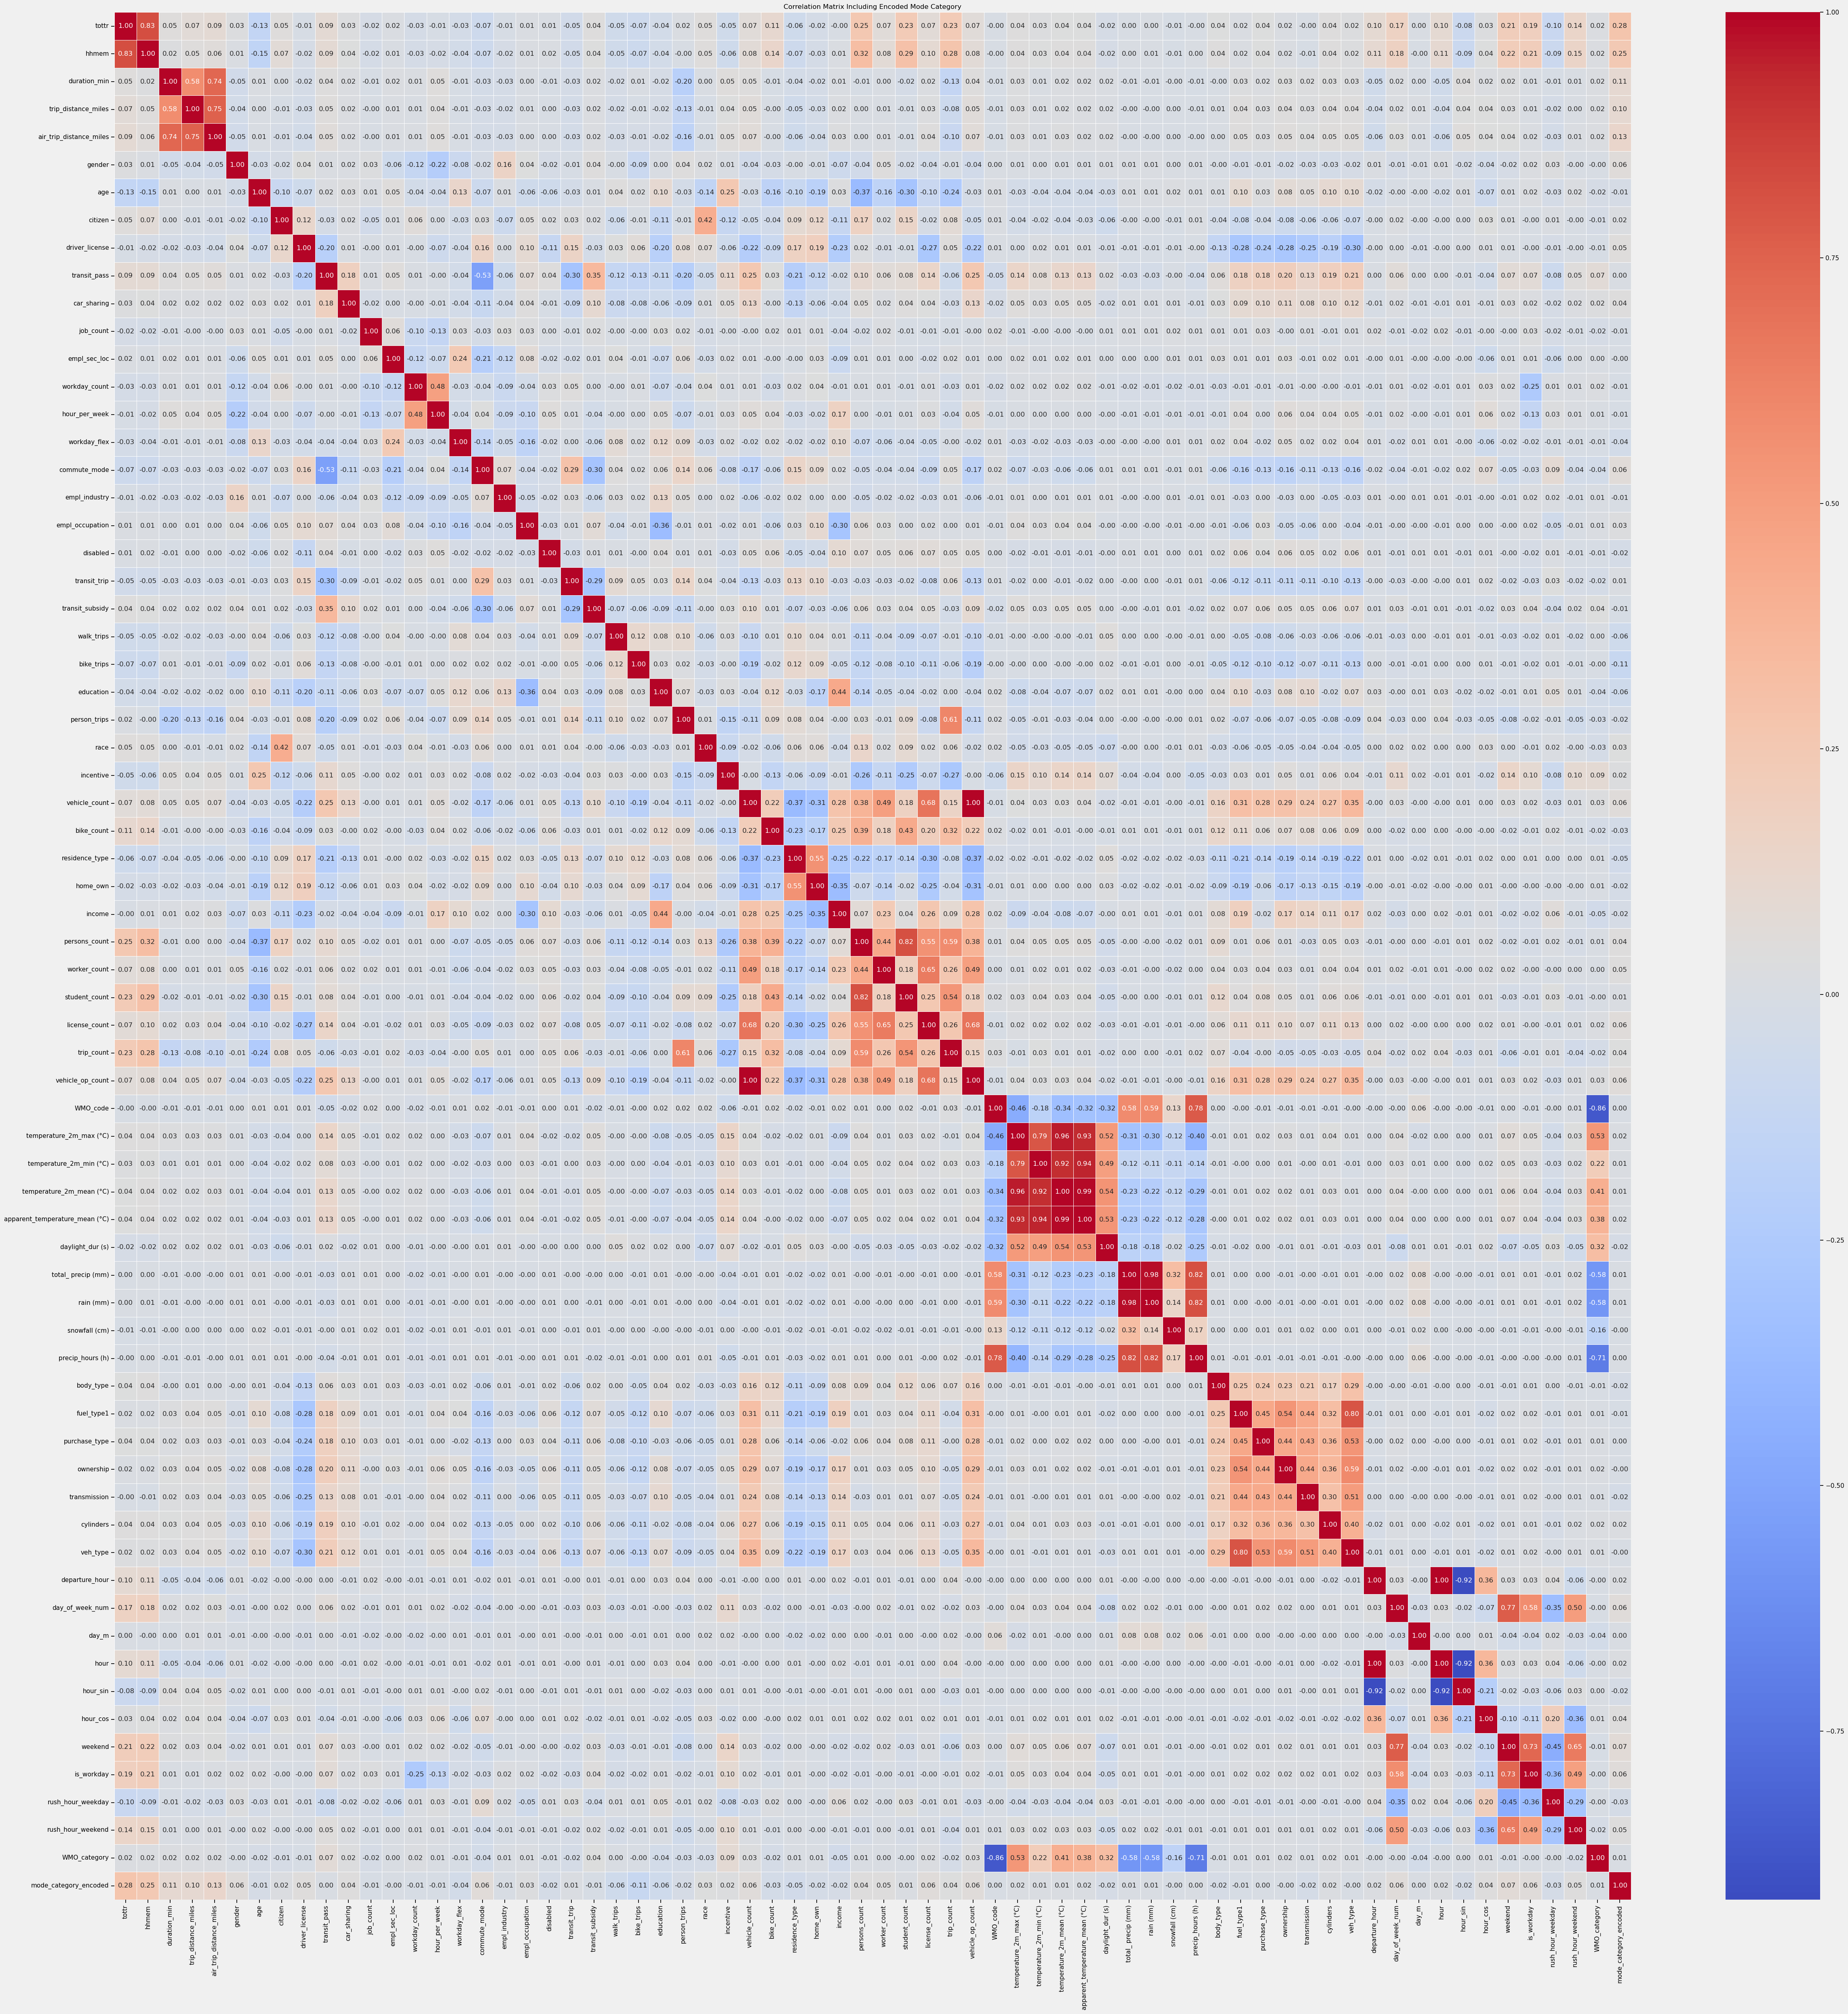

In [17]:
label_encoder = LabelEncoder()

# Copy the dataframe to preserve the original data
df_filtered_mod = workers_features.copy()

# Apply LabelEncoder to 'mode_category' column
df_filtered_mod['mode_category_encoded'] = label_encoder.fit_transform(df_filtered_mod['mode_category'])

# Select only numeric columns for correlation calculation
numeric_cols = df_filtered_mod.select_dtypes(include=['number']).columns

# Set up the correlation matrix for numeric columns
corr_matrix = df_filtered_mod[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Including Encoded Mode Category")
plt.tight_layout() 
plt.show()

# Feature Selection

In [18]:
def selected_feature(data):
    
    feature_selected = ['air_trip_distance_miles',
                        'transit_pass',
                        'transit_trip',
                        'vehicle_op_count',
                        'hour_cos',
                        'hour_sin',
                        'gender',
                        'bike_trips',
                        'daylight_dur (s)',
                        'apparent_temperature_mean (°C)',
                        'walk_trips',
                        'age',
                        'empl_occupation',
                        'day_of_week_num',
                        'empl_industry',
                        'body_type',
                        'education',
                        'hour_per_week',
                        'transit_subsidy',
                        'cylinders',
                        'license_count',
                        'workday_flex',
                        'income',
                        'WMO_code',
                        'transmission',
                        'bike_count',
                        'workday_count',
                        'veh_type',
                        'persons_count',
                        'residence_type',
                        'student_count',
                        'driver_license',
                        'race',
                        'worker_count',
                        ]

    selected_data = data[feature_selected]
    
    return selected_data

# Evaluate Performace of the Untuned Model

In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter


# Split the data into train and  temp
train_df, temp_df = train_test_split(workers_features, test_size=0.3, stratify=workers_features['mode_category'], random_state=42)

# Split into val and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)
X_train = selected_feature(train_df)
y_train = train_df['mode_category']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']
X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Class distribution before SMOTE: Counter({'Auto Driver': 48509, 'Active Transportation': 8419, 'Auto Passenger': 7297, 'Transit': 2058})
Class distribution after SMOTE: Counter({'Auto Driver': 48509, 'Auto Passenger': 48509, 'Transit': 48509, 'Active Transportation': 48509})
Training set size: 194036
Validation set size: 14204
Test set size: 14204


In [20]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Check class distribution
unique, counts = np.unique(y_val, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Generate classification report
report = classification_report(y_val, y_pred, target_names=['Active Transportation', 'Auto Driver', 'Auto Passenger', 'Transit'], digits=3)
print("\nClassification Report:\n", report)

# Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

Class Distribution: {'Active Transportation': 1804, 'Auto Driver': 10395, 'Auto Passenger': 1564, 'Transit': 441}

Classification Report:
                        precision    recall  f1-score   support

Active Transportation      0.827     0.851     0.839      1804
          Auto Driver      0.914     0.960     0.936     10395
       Auto Passenger      0.833     0.527     0.646      1564
              Transit      0.711     0.692     0.701       441

             accuracy                          0.890     14204
            macro avg      0.821     0.758     0.781     14204
         weighted avg      0.887     0.890     0.885     14204


Weighted F1-Score: 0.8846705135743798



Importance of Features:
                           Feature  Importance
0          air_trip_distance_miles    0.231172
1                     transit_pass    0.080323
2                     transit_trip    0.067702
3                 vehicle_op_count    0.039517
5                         hour_sin    0.037854
4                         hour_cos    0.037140
6                           gender    0.029242
8                 daylight_dur (s)    0.029169
7                       bike_trips    0.028400
9   apparent_temperature_mean (°C)    0.027348
13                 day_of_week_num    0.025780
10                      walk_trips    0.025583
11                             age    0.025465
12                 empl_occupation    0.022225
15                       body_type    0.021608
14                   empl_industry    0.021295
19                       cylinders    0.019963
17                   hour_per_week    0.019356
16                       education    0.019277
24                    transmission 

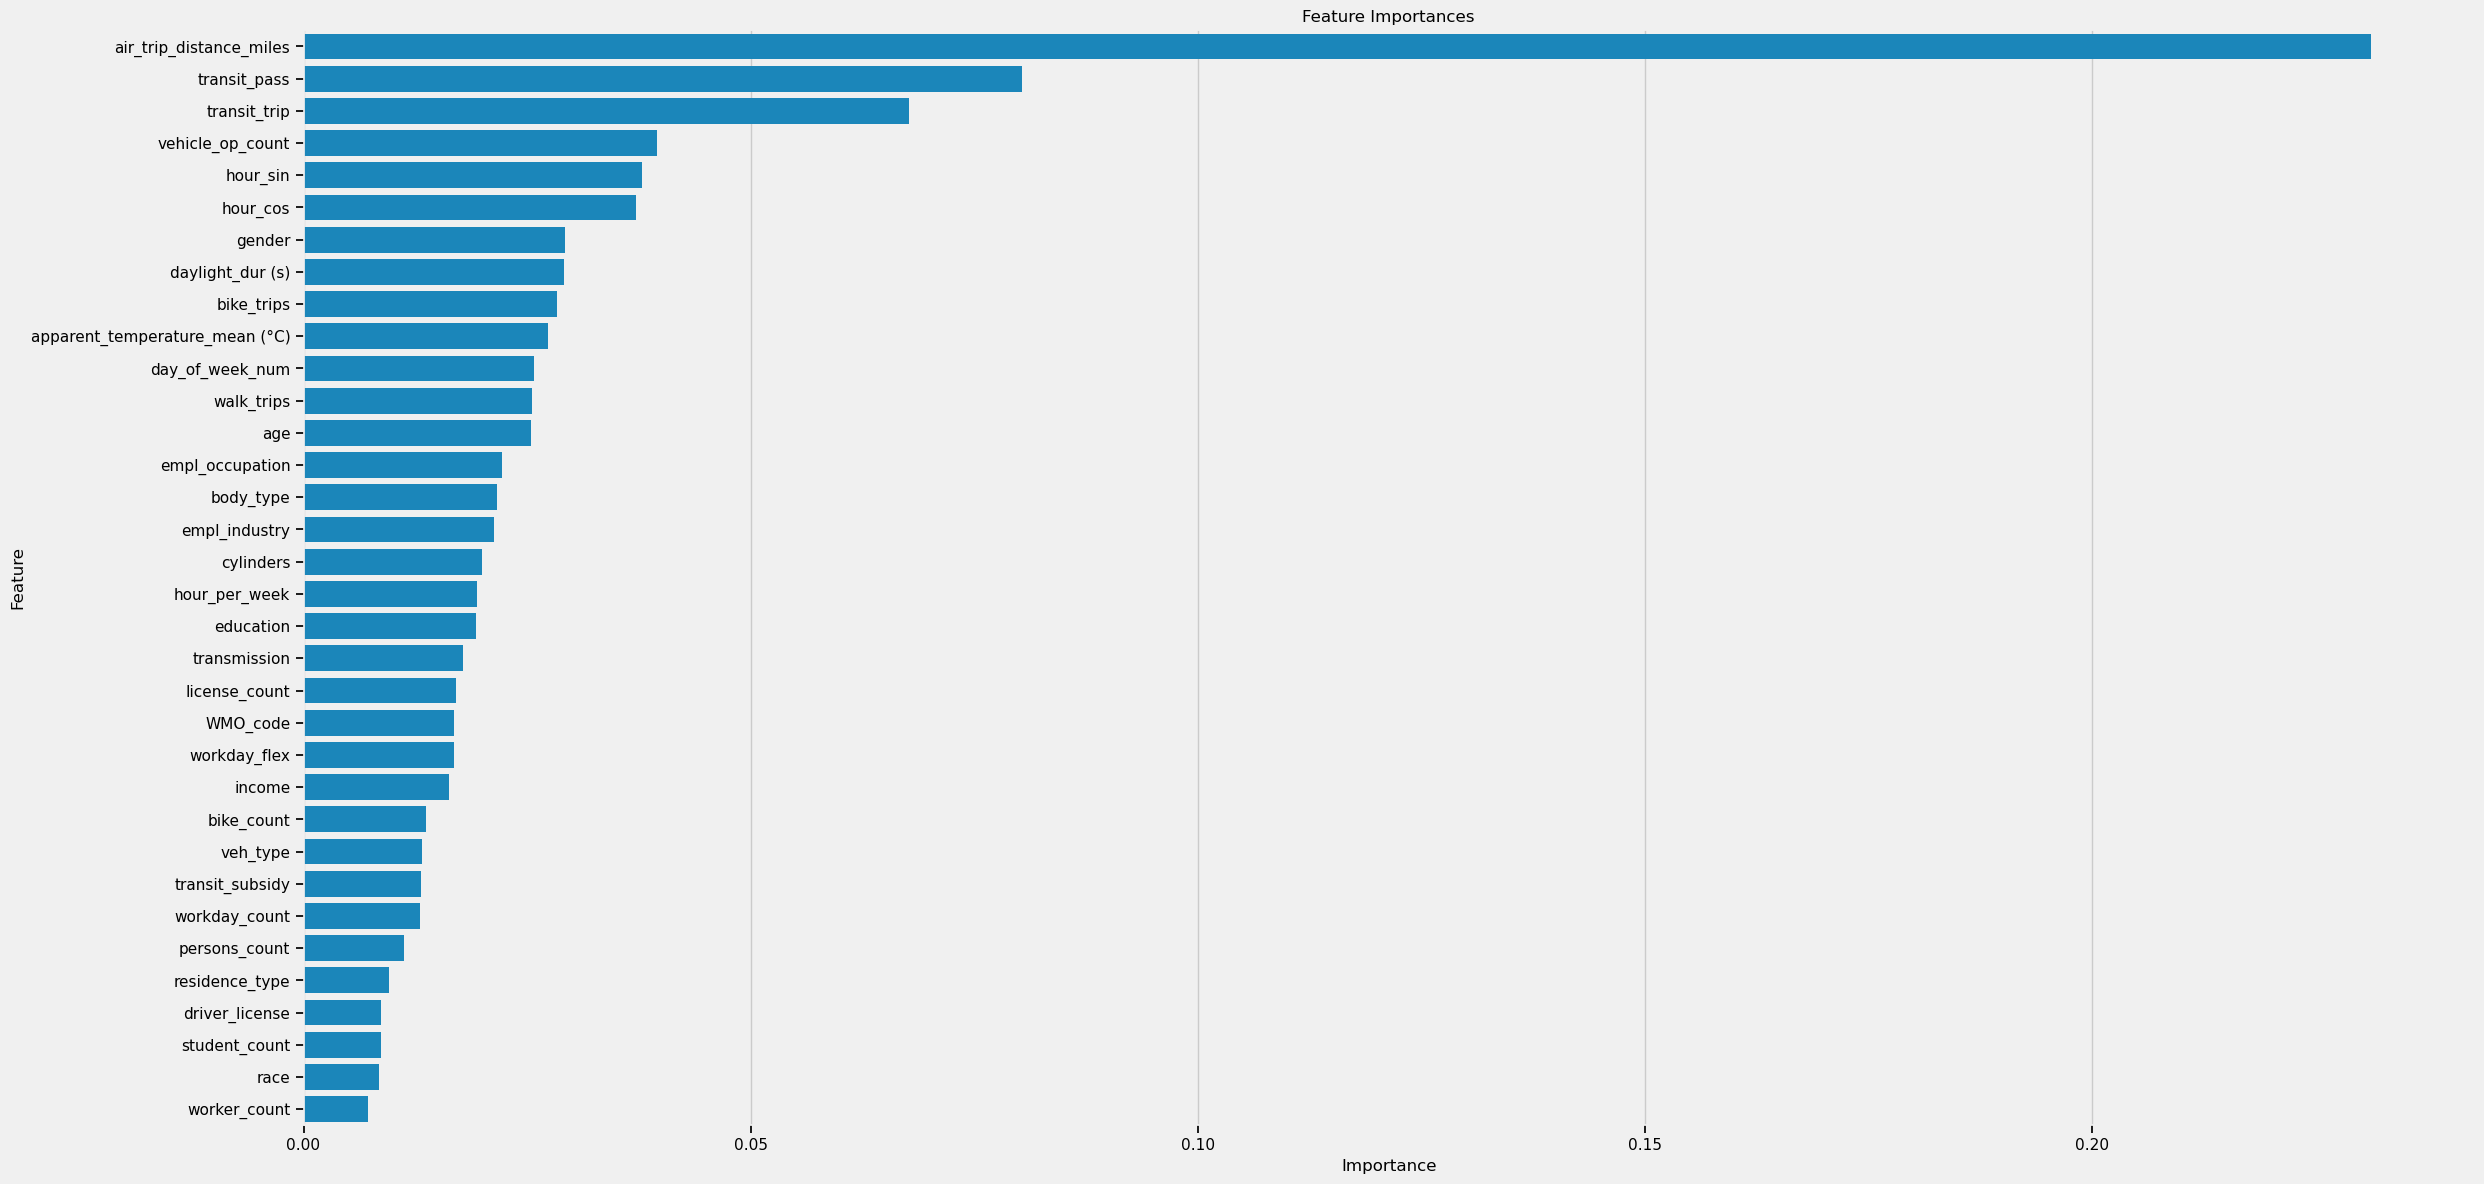

In [22]:
# Feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the features
print("\nImportance of Features:")
print(feature_importance_df.head(100))

# Plot the feature importances
plt.figure(figsize=(25, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100))
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [23]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Hypertuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters to tune
param_dist = {
    'n_estimators': [100,150],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2],
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=5, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Use the best model to make predictions
best_rf = random_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best cross-validation score:  0.9551324074366677


# Improving the F1 Scores by Adjusting Theresholds 

In [25]:
best_rf.fit(X_train_resampled, y_train_resampled)
y_probs = best_rf.predict_proba(X_val)

#### Intial Values with 0.5 Threshold

In [26]:
from sklearn.metrics import classification_report

# Default predictions based on max probability
y_pred_default = best_rf.predict(X_val)
print(classification_report(y_val, y_pred_default,digits=3))

                       precision    recall  f1-score   support

Active Transportation      0.826     0.838     0.832      1804
          Auto Driver      0.912     0.960     0.936     10395
       Auto Passenger      0.825     0.531     0.646      1564
              Transit      0.707     0.683     0.694       441

             accuracy                          0.889     14204
            macro avg      0.818     0.753     0.777     14204
         weighted avg      0.885     0.889     0.883     14204



#### ADJUST THRESHOLDS FOR EACH MODE

In [27]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Initialize a dictionary to store thresholds
optimal_thresholds = {}

# Iterate over each class
for class_index, class_name in enumerate(best_rf.classes_):
    # Get probabilities for this class
    class_probs = y_probs[:, class_index]

    # Create binary labels for this class (OvA)
    binary_y_val = (y_val == class_name).astype(int)

    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(binary_y_val, class_probs)

    # Calculate F1 score and find the threshold that maximizes it
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]
    optimal_thresholds[class_name] = best_threshold

print("Optimal thresholds:", optimal_thresholds)

Optimal thresholds: {'Active Transportation': 0.41, 'Auto Driver': 0.49, 'Auto Passenger': 0.33, 'Transit': 0.39}


# Make Predictions Using Optimized Thresholds

For each sample, the code checks whether the predicted probability for each class meets or exceeds the optimal threshold for that class.
If the threshold is met, it adjusts the prediction for that class. The final predicted class is the one with the highest adjusted probability.

In [28]:
# Initialize adjusted predictions
y_pred_adjusted = []

# Iterate over each sample
for probs in y_probs:
    # Apply thresholds for each class
    adjusted_probs = [probs[i] >= optimal_thresholds[class_name] 
                      for i, class_name in enumerate(best_rf.classes_)]
    
    # Predict the class with the highest adjusted probability
    y_pred_adjusted.append(best_rf.classes_[np.argmax(adjusted_probs)])

# Convert to array
y_pred_adjusted = np.array(y_pred_adjusted)

In [29]:
print(classification_report(y_val, y_pred_adjusted,digits=3))
# Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred_adjusted, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

                       precision    recall  f1-score   support

Active Transportation      0.772     0.873     0.819      1804
          Auto Driver      0.921     0.949     0.935     10395
       Auto Passenger      0.819     0.548     0.656      1564
              Transit      0.709     0.669     0.688       441

             accuracy                          0.886     14204
            macro avg      0.805     0.759     0.775     14204
         weighted avg      0.884     0.886     0.882     14204


Weighted F1-Score: 0.8817580625972722


# Test on the test data 


In [ ]:
# Separate features (X) and target (y) for test_df
X_test = test_df.drop('mode_category', axis=1) 
y_test = test_df['mode_category']  # The target variable
X_test = selected_feature(X_test)
# Make predictions on the test set
y_pred_test = best_rf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred_test,digits=3)
print("Classification Report:\n", report)

# Calculate the weighted F1 score
weighted_f1 = f1_score(y_test, y_pred_test, average='weighted')
print("Weighted F1 Score: ", weighted_f1)

Classification Report:
                        precision    recall  f1-score   support

Active Transportation      0.811     0.834     0.822      1805
          Auto Driver      0.913     0.961     0.936     10395
       Auto Passenger      0.830     0.523     0.642      1563
              Transit      0.660     0.637     0.648       441

             accuracy                          0.886     14204
            macro avg      0.803     0.739     0.762     14204
         weighted avg      0.883     0.886     0.880     14204

Weighted F1 Score:  0.8804453193100753


### Gradient Boosting (excluded as it did not improve performance)

In [31]:
# # Import required libraries
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import confusion_matrix

# # Initialize the Gradient Boosting Classifier
# gb_clf = GradientBoostingClassifier(random_state=42)

# # Fit the model to the training data
# gb_clf.fit(X_train_resampled, y_train_resampled)

# # Predict on the test set
# y_pred_gb = gb_clf.predict(X_val)

# # Evaluate the model
# print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))
# print("\nClassification Report:\n", classification_report(y_val, y_pred_gb))
# print("\nAccuracy Score:", accuracy_score(y_val, y_pred_gb))

### Confusion Matrix

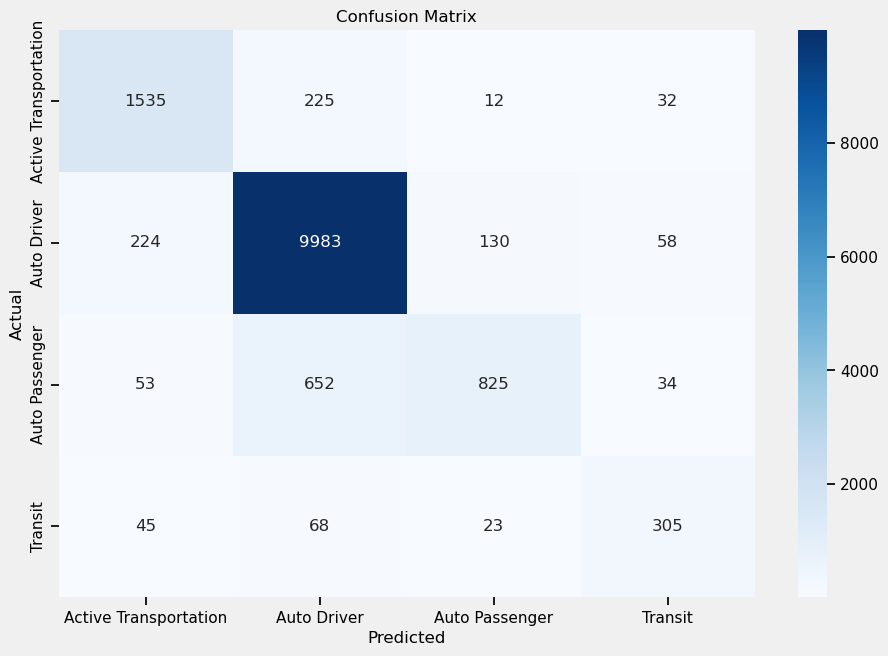

In [32]:
# Create a confusion matrix for RandomForestClassifier
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)

# Set up correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

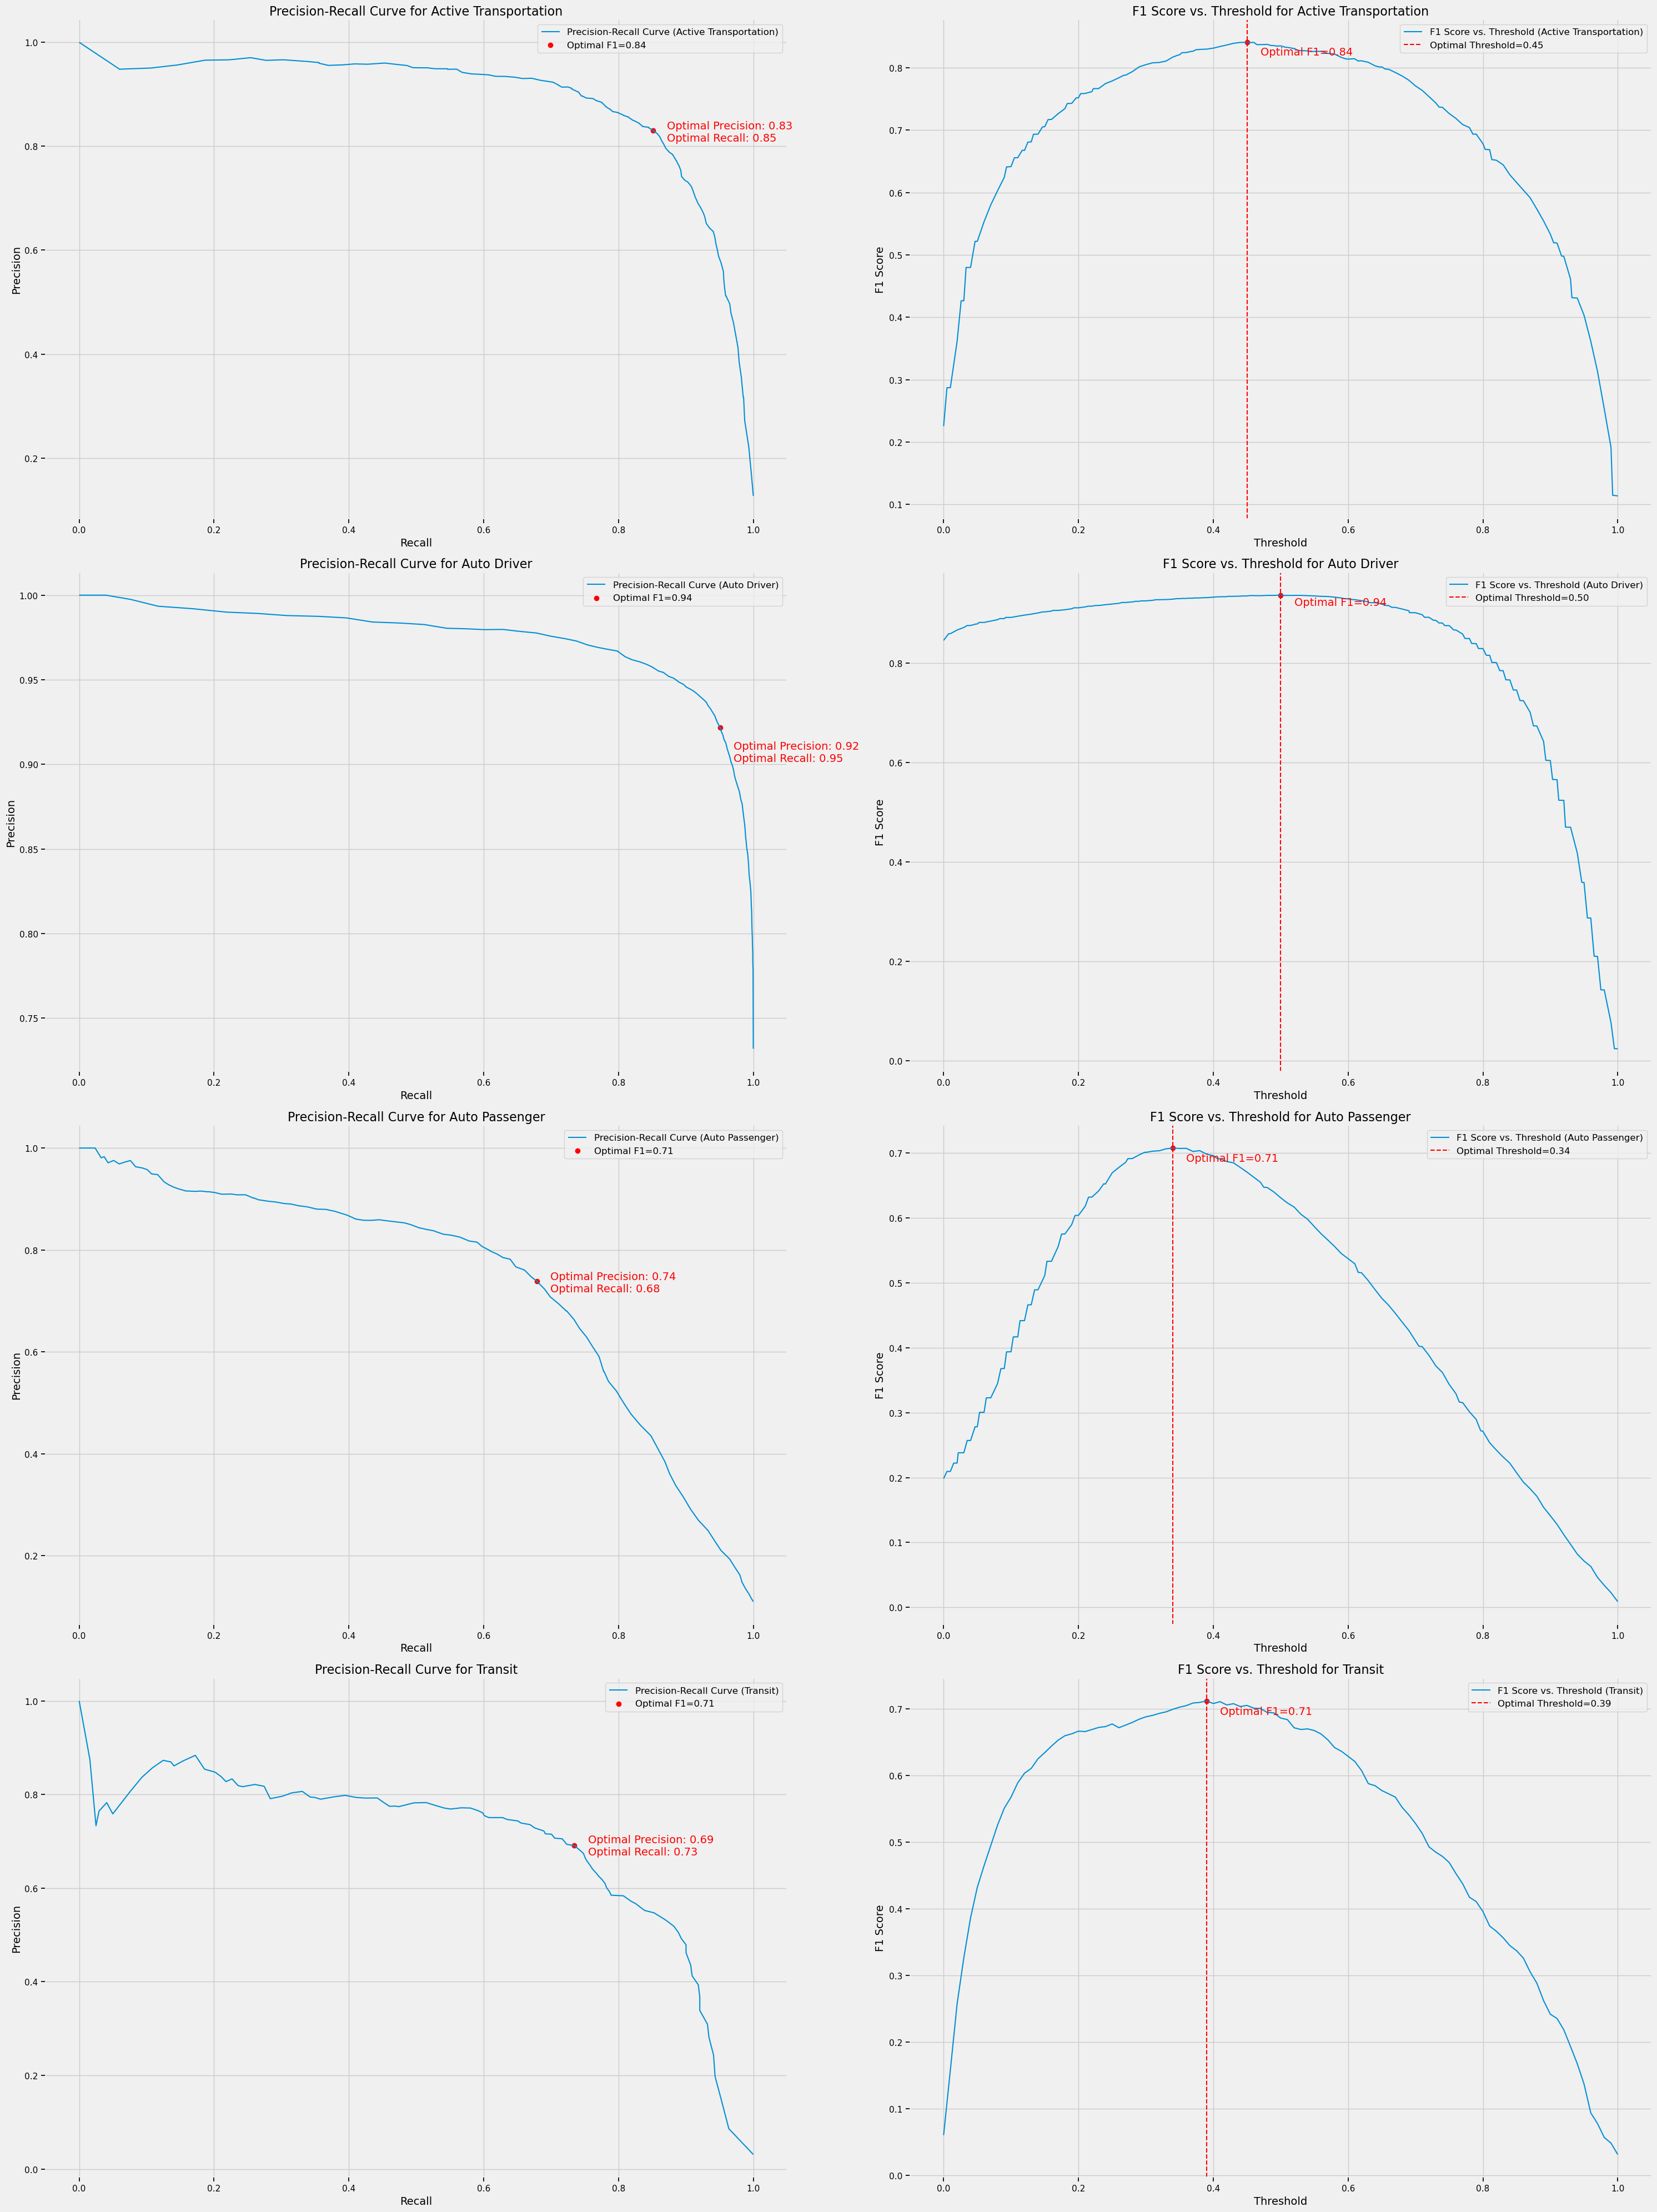

In [33]:
from sklearn.metrics import precision_recall_curve

# List of target classes
target_classes = ['Active Transportation', 'Auto Driver', 'Auto Passenger', 'Transit']

# Set up the plot
plt.figure(figsize=(30, 40))

for idx, target_class in enumerate(target_classes):
    # Convert y_val to binary: 1 for the target class, 0 otherwise
    y_binary = (y_val == target_class).astype(int)

    # Predict probabilities for all classes (for RandomForestClassifier, for example)
    y_probs = model.predict_proba(X_val)  # Get probabilities for all classes

    # Identify the index of the target class in the model's classes_
    target_class_index = list(model.classes_).index(target_class)

    # Extract probabilities for the target class
    y_probs_target = y_probs[:, target_class_index]

    # Calculate precision, recall, and thresholds for the Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_binary, y_probs_target)

    # Calculate F1 scores for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the optimal threshold for the highest F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_f1 = f1_scores[optimal_idx]
    optimal_threshold = thresholds[optimal_idx] if len(thresholds) > 0 else 1  # Handle case when thresholds are empty

# Subplot 1: Precision-Recall curve for each target class
    plt.subplot(len(target_classes), 2, 2 * idx + 1)
    plt.plot(recall, precision, label=f"Precision-Recall Curve ({target_class})")
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal F1={optimal_f1:.2f}')
    plt.text(recall[optimal_idx] + 0.02, precision[optimal_idx] - 0.02, 
             f'Optimal Precision: {precision[optimal_idx]:.2f}\nOptimal Recall: {recall[optimal_idx]:.2f}', 
             color='red', fontsize=14) 
    plt.xlabel('Recall', fontsize=14)  
    plt.ylabel('Precision', fontsize=14)  
    plt.title(f'Precision-Recall Curve for {target_class}', fontsize=16)  
    plt.legend(fontsize=12)  
    plt.grid(True)

    # Subplot 2: F1 vs. Threshold for each target class
    plt.subplot(len(target_classes), 2, 2 * idx + 2)
    plt.plot(thresholds, f1_scores[:-1], label=f"F1 Score vs. Threshold ({target_class})")  # Exclude the last threshold (no corresponding F1 score)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold={optimal_threshold:.2f}')
    plt.scatter(optimal_threshold, optimal_f1, color='red')
    plt.text(optimal_threshold + 0.02, optimal_f1 - 0.02, f'Optimal F1={optimal_f1:.2f}', color='red', fontsize=14) 
    plt.xlabel('Threshold', fontsize=14)  
    plt.ylabel('F1 Score', fontsize=14)  
    plt.title(f'F1 Score vs. Threshold for {target_class}', fontsize=16) 
    plt.legend(fontsize=12)  

# Show the plots
plt.tight_layout()
plt.show()

In [34]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)